In [1]:
from numba import cuda,float64

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator
print(cuda.gpus)

<Managed Device 0>


In [2]:
class CUDATimer:
    def __init__(self, stream):
        self.stream = stream
        self.elapsed = None  # in ms

    def __enter__(self):
        self.event_beg = cuda.event()
        self.event_end = cuda.event()
        self.event_beg.record(stream=self.stream)
        return self

    def __exit__(self, type, value, traceback):
        self.event_end.record(stream=self.stream)
        self.event_end.wait(stream=self.stream)
        self.event_end.synchronize()
        self.elapsed = self.event_beg.elapsed_time(self.event_end)

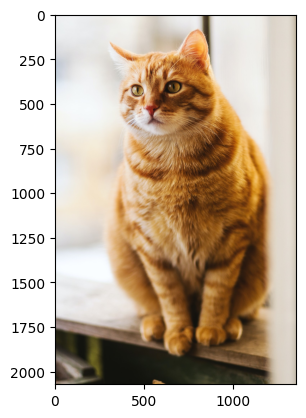

In [3]:
cell_size = (8, 8)
block_size = (2, 2)
img = Image.open('./Picture/cat-1.jpg')
new_width  =  img.size[0] // cell_size[0] * cell_size[0]
new_height =  img.size[1] // cell_size[1] * cell_size[1]
img = img.resize((new_width,new_height), Image.LANCZOS)
# img = img.resize((64,128), Image.LANCZOS)
img_pixel = np.array(img)
plt.imshow(img_pixel)

In [4]:
pixel = np.array(img)
pixel.shape

(2072, 1352, 3)

In [5]:
@cuda.jit
def gray_kernel(picture_in, gray_out):    
    row, col = cuda.grid(2)
    image_rows, image_cols,channel = picture_in.shape
    if (row >= image_rows) or (col >= image_cols): 
        return
    rgb                = picture_in[row][col]
    gray_out[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    # assuming x and y inputs are same length

In [6]:
# Memory Allocation
out_host   = np.empty([pixel.shape[0], pixel.shape[1]],dtype = pixel.dtype)
x_device   = cuda.to_device(pixel)
height     = cuda.to_device(pixel.shape[0])
width      = cuda.to_device(pixel.shape[1])
out_device = cuda.device_array_like(out_host)

In [7]:
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(pixel.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(pixel.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
gray_kernel[blockspergrid, threadsperblock](x_device, out_device)

In [8]:
out_host = out_device.copy_to_host()

In [9]:
out_host

array([[238, 238, 238, ..., 170, 169, 165],
       [237, 237, 237, ..., 169, 168, 165],
       [237, 237, 237, ..., 169, 168, 165],
       ...,
       [133, 131, 128, ..., 180, 178, 176],
       [134, 126, 122, ..., 180, 179, 175],
       [129, 122, 115, ..., 180, 179, 175]], dtype=uint8)

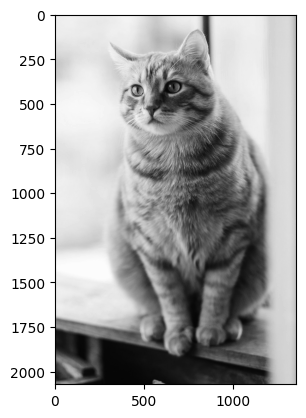

In [10]:
plt.imshow(out_host,cmap='gray')

In [11]:
sobel_x = np.array([-1,0,1])
sobel_y = np.array([[-1],
                    [0],
                    [1]])

# [0] là theo trục y, [1] là theo trục x
cell_size = (8, 8)
block_size = (2, 2)
hist_size = 9

height, width, channel = pixel.shape

n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_size[0] + 1, n_cell[1] - block_size[1] + 1)
print(n_cell,n_block)

(259, 169) (258, 168)


In [2]:
def calc_gradient_2(input, width, height):
    output_x = np.zeros((height,width))
    output_y = np.zeros((height,width))

    for r in range(height):
        for c in range(width):
            for filter_R in range(-1,2):
                for filter_C in range(-1,2):
                    pixel_r = r + i
                    pixel_r = min(max(0, pixel_r), height - 1)
                    output_y[r,c] += input[pixel_r,c] * i

                    pixel_c = c + i
                    pixel_c = min(max(0, pixel_c), width - 1)
                    output_x[r,c] += input[r,pixel_c] * i

    return output_x, output_y

In [12]:
def calc_gradient(input, width, height):
  output_x = np.zeros((height,width))
  output_y = np.zeros((height,width))

  for r in range(height):
    for c in range(width):

      for i in range(-1,2):
        pixel_r = r + i
        pixel_r = min(max(0, pixel_r), height - 1)
        output_y[r,c] += input[pixel_r,c] * i

        pixel_c = c + i
        pixel_c = min(max(0, pixel_c), width - 1)
        output_x[r,c] += input[r,pixel_c] * i

  return output_x, output_y

In [13]:
gradient_x, gradient_y = calc_gradient(out_host, width, height)

In [14]:
magnitude = np.sqrt(np.square(gradient_x)+np.square(gradient_y))

In [15]:
direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y), np.array(gradient_x)))), 360)

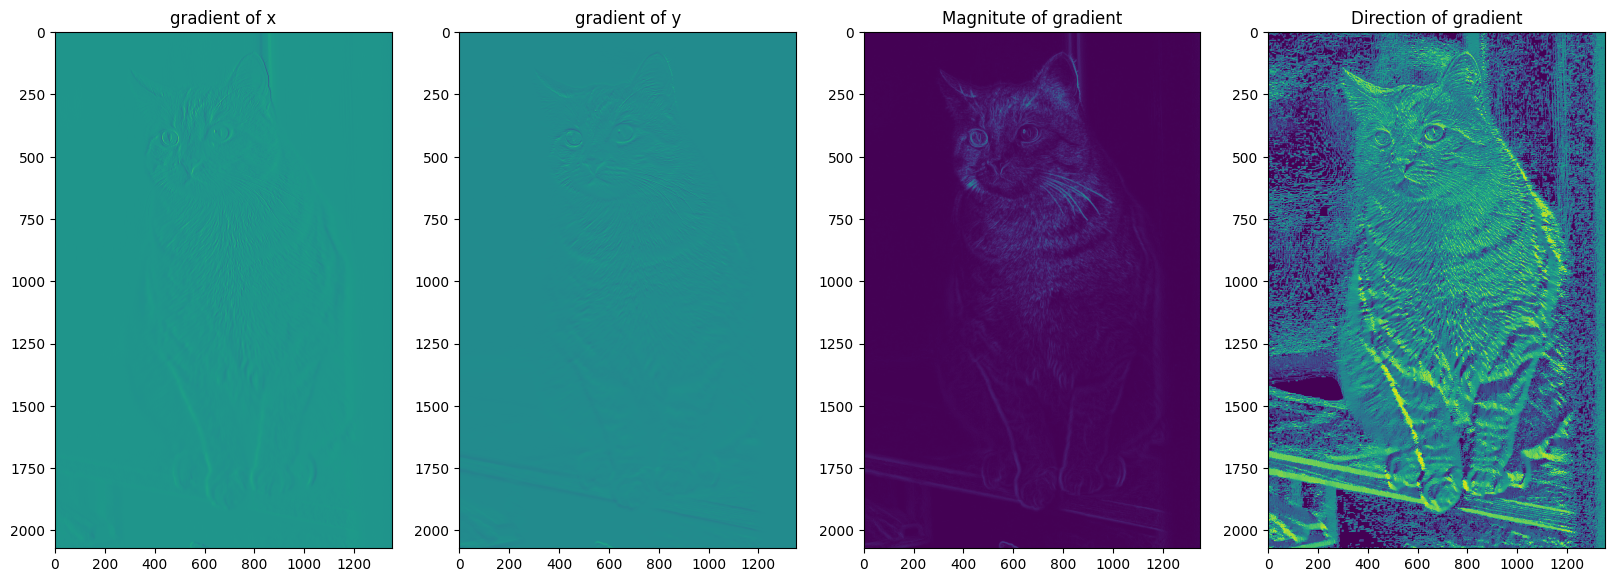

In [16]:
w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gradient_x)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gradient_y)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(magnitude)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(direction)

In [17]:
def cell_hist(direction, magnitude, idx, idy, width, height, cell_size, sbin):
    output = np.zeros(9) # output = [0,0,0,0,0,0,0,0,0]
    
    # duyệt qua kích thước cell theo chiều cao
    for r in range(cell_size[0]):
      # duyệt qua kích thước cell theo chiều rộng
        for c in range(cell_size[1]):
          # cột và dòng hiện tại trong ảnh
            cur_r = idy*cell_size[0] + r
            cur_c = idx*cell_size[1] + c
            # kiểm tra
            if cur_r>=height or cur_c >= width:
                break

            # chia lấy phần nguyên và phần dư
            quotient = int(direction[cur_r][cur_c]//sbin)
            remainder = direction[cur_r][cur_c] % sbin

            if remainder==0:
                output[quotient] += magnitude[cur_r][cur_c]
            else:
                first_bin = quotient

                second_bin = first_bin+1

                output[first_bin] += magnitude[cur_r][cur_c]*\
                    ((second_bin*sbin - direction[cur_r][cur_c])/(second_bin*sbin - first_bin*sbin))
                    
                second_bin_idx = second_bin
                if second_bin > 8:
                    second_bin_idx = 0
                output[second_bin_idx] += magnitude[cur_r][cur_c]*\
                    ((direction[cur_r][cur_c] - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))
    return output

In [18]:
out = cell_hist(direction, magnitude, 0, 0, width, height, cell_size, 40)

In [19]:
out

array([ 0.        ,  0.        ,  6.        ,  2.        ,  0.5       ,
        1.03033009,  4.63388348, 11.25      ,  0.        ])

In [20]:
hist = []

for y in range(0,n_cell[0]):
    row = []
    for x in range(0,n_cell[1]):
        output = cell_hist(direction,magnitude,x,y,width,height,cell_size,40)
        row.append(output)
    hist.append(row)
hist = np.array(hist)
print(hist.shape)
print(n_cell)
print(hist.dtype)

(259, 169, 9)
(259, 169)
float64


In [461]:
def l2_cal(n_block,hist):
    l2 = np.empty(n_block)
    for i in range(n_block[0]):
        for j in range(n_block[1]):
            l2[i][j] = math.sqrt(np.sum(np.square(hist[i:i+2, j:j+2])))
    return l2
l2 = l2_cal(n_block,hist)

In [22]:
# threadsperblock = (32, 32)
# x_Dim = threadsperblock[0]//cell_size[0] 
# y_Dim = threadsperblock[1]//cell_size[1] * 2
# print(x_Dim, y_Dim)
# sbin_1 = 9
# size = x_Dim * y_Dim * sbin_1 
# @cuda.jit 
# def hist_kernel(direction, magnitude, cell_size, d_sbin, result_out, n_cell):    
#     cur_r, cur_c  = cuda.grid(2)
#     height, width = direction.shape
#     cur_r = cur_r 
#     cur_c = cur_c * 2
#     cur_r_1 = cur_r 
#     cur_c_1 = cur_c + 1
#     # Creat 3D shared array
#     shared     = cuda.shared.array(shape=size, dtype=float64)
   
#     idy   = operator.floordiv(cur_r,cell_size[0])
#     idx   = operator.floordiv(cur_c,cell_size[1])
#     sbin  = d_sbin


#     idy_shared = operator.mod(idy,x_Dim)
#     idx_shared = operator.mod(idx,y_Dim)
#     share_index =  idy_shared + idx_shared
#     share_index = share_index + (idy_shared * 7)



#     if cur_r%(cell_size[0]) == 0 :
#         check   = int(cur_c  %(cell_size[1]/2))
#         check_2 = int(cur_c_1%(cell_size[1]/2))
#         if check < 4:
#             shared[share_index * sbin_1 + (check * 2)]     = 0
#             shared[share_index * sbin_1 + (check * 2) + 1] = 0
#         if check_2 <4:
#             shared[share_index * sbin_1 + (check_2 * 2)]     = 0
#             shared[share_index * sbin_1 + (check_2 * 2) + 1] = 0
#         if check == 0:
#             shared[share_index * sbin_1 + 8] = 0
#     index_thread = share_index * sbin_1
#     cuda.syncthreads()
#      # kiểm tra
#     if cur_r < height and cur_c < width:
#         thread_direction = direction[cur_r][cur_c]
#         thread_mag       = magnitude[cur_r][cur_c]
#         # chia lấy phần nguyên và phần dư
#         quotient  =     operator.floordiv(thread_direction,sbin)
#         remainder =     operator.mod(thread_direction,sbin)
#         if remainder==0:
#             cuda.atomic.add(shared, (index_thread + quotient), thread_mag)
#         else:
#             first_bin = quotient

#             second_bin     = first_bin+1
#             need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
#             cuda.atomic.add(shared, (index_thread + first_bin), need_to_add)


#             second_bin_idx = second_bin
#             if second_bin > 8:
#                 second_bin_idx = 0
#             need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))  
#             cuda.atomic.add(shared, (index_thread + second_bin_idx), need_to_add_2)
            
#     if  cur_r_1 < height and cur_c_1 < width:
#         thread_direction = direction[cur_r_1][cur_c_1]
#         thread_mag       = magnitude[cur_r_1][cur_c_1]
#         # chia lấy phần nguyên và phần dư
#         quotient  =     operator.floordiv(thread_direction,sbin)
#         remainder =     operator.mod(thread_direction,sbin)
#         if remainder==0:
#             cuda.atomic.add(shared, (index_thread + quotient), thread_mag)
#         else:
#             first_bin = quotient

#             second_bin     = first_bin+1
#             need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
#             cuda.atomic.add(shared, (index_thread + first_bin), need_to_add)


#             second_bin_idx = second_bin
#             if second_bin > 8:
#                 second_bin_idx = 0
#             need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))  
#             cuda.atomic.add(shared, (index_thread + second_bin_idx), need_to_add_2)

#     cuda.syncthreads()
    
#     result_index = idx + y*xMax + z*yMax*xMax
#     if cur_r%(cell_size[0]) == 0 :
#         check   = int(cur_c  %(cell_size[1]/2))
#         check_2 = int(cur_c_1%(cell_size[1]/2))
#         if check < 4  :
#             result_out[idy][idx][check * 2]         = shared[index_thread + (check * 2)] 
#             result_out[idy][idx][(check * 2) + 1]   = shared[index_thread + (check * 2) + 1] 
#         if check_2 < 4:
#             result_out[idy][idx][check * 2]         = shared[index_thread + (check_2 * 2)] 
#             result_out[idy][idx][(check * 2) + 1]   = shared[index_thread + (check_2 * 2) + 1] 
#         if check == 0:
#             result_out[idy][idx][8]                 = shared[index_thread + 8] 
#     if (idy==1) and (idx==0) and cur_r == 8 and cur_c == 0:
#         print(share_index, check, check_2, result_index * sbin_1 )
#         for i in range(9):
            print(shared[index_thread + i])?
    

In [23]:
# x_Dim   = threadsperblock[0]//cell_size[0]
# y_Dim   = threadsperblock[1]//cell_size[1]
# print(x_Dim, y_Dim)
# sbin_1 = 9
# sbin_size = 10
# @cuda.jit(fastmath=True)
# def hist_kernel(direction, magnitude, cell_size, d_sbin, result_out):    
#     cur_r, cur_c  = cuda.grid(2)
#     height, width = direction.shape

#     idy   = int(cur_r//cell_size[0])
#     idx   = int(cur_c//cell_size[1])
#     sbin  = d_sbin
    
#     # Creat 3D shared array
#     shared     = cuda.shared.array(shape=(x_Dim, y_Dim_2, sbin_size), dtype=float64)
#     idy_shared = idy%x_Dim
#     idx_shared = idx%y_Dim
#     if cur_r%cell_size[0] == 0:
#         check   = int(cur_c  %(cell_size[1]))
#         if check < 4:
#             shared[idy_shared][idx_shared][check* 2   ] = 0.0
#             shared[idy_shared][idx_shared][check*2 + 1] = 0.0
#         if check == 0:
#             shared[idy_shared][idx_shared][8] = 0.0

#     cuda.syncthreads()
#     # kiểm tra
#     if cur_r>=height or cur_c>= width:
#         return
#     thread_direction = direction[cur_r][cur_c]
#     thread_mag       = magnitude[cur_r][cur_c]
#     # chia lấy phần nguyên và phần dư
#     quotient  = int(thread_direction//sbin)
#     remainder =     thread_direction % sbin

#     if remainder==0:
#         cuda.atomic.add(shared, (idy_shared, idx_shared, quotient), thread_mag)
#     else:
#         first_bin = quotient
#         second_bin     = first_bin+1
#         need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
#         cuda.atomic.add(shared, (idy_shared, idx_shared, first_bin), need_to_add)

            
#         second_bin_idx = second_bin
#         if second_bin > 8:
#             second_bin_idx = 0
#         need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))   

#         cuda.atomic.add(shared, (idy_shared, idx_shared, second_bin_idx), need_to_add_2)

    
#     cuda.syncthreads()
#     if cur_r%cell_size[0] == 0:
#         check   = int(cur_c  %(cell_size[1]))
#         if check < 4:
#             result_out[idy][idx][check* 2]     = shared[idy_shared][idx_shared][check* 2]
#             result_out[idy][idx][check*2 + 1] = shared[idy_shared][idx_shared][check* 2 +1]
#         if check == 0:
#             result_out[idy][idx][8]            = shared[idy_shared][idx_shared][8]

In [328]:
# x_Dim   = threadsperblock[0]//cell_size[0]
# y_Dim   = threadsperblock[1]//cell_size[1] * 2
# print(x_Dim, y_Dim)
# sbin_1 = 9
# sbin_size = 10
# @cuda.jit(fastmath=True)
# def hist_kernel(direction, magnitude, cell_size, d_sbin, result_out,out_l2):    
#     cur_r, cur_c  = cuda.grid(2)
#     height, width = direction.shape

#     idy   = int(cur_r//cell_size[0])
#     idx   = int(cur_c//cell_size[1])
#     sbin  = d_sbin
    
#     # Creat 3D shared array
#     shared     = cuda.shared.array(shape=(x_Dim, y_Dim, sbin_size), dtype=float64)
#     l2         = cuda.shared.array(shape=(x_Dim, y_Dim), dtype=float64)
#     idy_shared = idy%x_Dim
#     idx_shared = idx%y_Dim
    
#     condition_1 = cur_r%cell_size[0]
#     condition_2 = int(cur_c  %cell_size[1])
#     if  condition_1 == 0:
#         check   = condition_2 
#         if check < 4:
#             shared[idy_shared][idx_shared*2][check* 2    ] = 1.0
#             shared[idy_shared][idx_shared*2][check* 2 + 1] = 1.0
#             shared[idy_shared][idx_shared*2+1][check* 2    ] = 1.0
#             shared[idy_shared][idx_shared*2+1][check* 2 + 1] = 1.0
#     elif  condition_1 == 1:
#         check   = condition_2 
#         if check == 0:
#             shared[idy_shared][idx_shared][8] = 1.0
#             shared[idy_shared][idx_shared*2+1][8] = 1.0
#             l2[idy_shared][idx_shared] = 1.0
    
#     cuda.syncthreads()
#     # kiểm tra
#     cur_r_1 = cur_r
#     cur_r_2 = cur_r
#     cur_c_1 = cur_c * 2
#     cur_c_2 = cur_c * 2 + 1
    
  
#     if (cur_r_1>=height or cur_c_1>= width) and (cur_r_2>=height or cur_c_2>= width):
#         return
#     if cur_r_1 < height and cur_c_1 < width:
#         idy_1   = int(cur_r_1//cell_size[0])
#         idx_1   = int(cur_c_1//cell_size[1])
#         idy_shared_1 = idy_1%x_Dim
#         idx_shared_1 = idx_1%y_Dim
#         thread_direction = direction[cur_r_1][cur_c_1]
#         thread_mag       = magnitude[cur_r_1][cur_c_1]
#         if idx == 2 and idy == 0:
#             print(cur_r_1,cur_c_1,idy_shared_1, idx_shared_1)
#         # chia lấy phần nguyên và phần dư
#         quotient  = int(thread_direction//sbin)
#         remainder =     thread_direction % sbin

#         if remainder==0:
#             cuda.atomic.add(shared, (idy_shared_1, idx_shared_1, quotient), thread_mag)

#         else:
#             first_bin = quotient
#             second_bin     = first_bin+1
#             need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/sbin)
#             cuda.atomic.add(shared, (idy_shared_1, idx_shared_1, first_bin), need_to_add)


#             second_bin_idx = second_bin
#             if second_bin > 8:
#                 second_bin_idx = 0
#             need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/sbin)   

#             cuda.atomic.add(shared, (idy_shared_1, idx_shared_1, second_bin_idx), need_to_add_2)
#     if cur_r_2 < height and cur_c_2 < width:

#         idy_2   = int(cur_r_2//cell_size[0])
#         idx_2   = int(cur_c_2//cell_size[1])
#         idy_shared_2 = idy_2%x_Dim
#         idx_shared_2 = idx_2%y_Dim
#         thread_direction = direction[cur_r_2][cur_c_2]
#         thread_mag       = magnitude[cur_r_2][cur_c_2]
# #         if idx == 0 and idy == 0:
# #             print(cur_r_2,cur_c_2,idy_shared_2, idx_shared_2)
#         # chia lấy phần nguyên và phần dư
#         quotient  = int(thread_direction//sbin)
#         remainder =     thread_direction % sbin

#         if remainder==0:
#             cuda.atomic.add(shared, (idy_shared_2, idx_shared_2, quotient), thread_mag)

#         else:
#             first_bin = quotient
#             second_bin     = first_bin+1
#             need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/sbin)
#             cuda.atomic.add(shared, (idy_shared_2, idx_shared_2, first_bin), need_to_add)


#             second_bin_idx = second_bin
#             if second_bin > 8:
#                 second_bin_idx = 0
#             need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/sbin)   

#             cuda.atomic.add(shared, (idy_shared_2, idx_shared_2, second_bin_idx), need_to_add_2)
    
#     cuda.syncthreads()
    
# #     if condition_1 == 0:
# #         check   = condition_2
# #         if check < 4:
# #             result_out[idy][idx][check* 2]     = shared[idy_shared][idx_shared][check* 2]
# #             result_out[idy][idx][check*2 + 1]  = shared[idy_shared][idx_shared][check* 2 +1]
# #             cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][check*2]**2)
# #             cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][check*2 +1]**2)
# #     elif  condition_1 == 1:
# #         if check == 0:
# #             cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][8]**2)
# #             result_out[idy][idx][8]            = shared[idy_shared][idx_shared][8]
# #             cuda.syncthreads()
# #             out_l2[idy][idx]                   = l2[idy_shared][idx_shared]
# #     else:
# #         return 
#     if cur_r%(cell_size[0]/2) == 0 and cur_c%(cell_size[1]/2)==0:
#         for index in range(sbin_1):
#             result_out[idy][idx][index] = shared[idy_shared][idx_shared][index]   


4 8


In [491]:
x_Dim   = threadsperblock[0]//cell_size[0]
y_Dim   = threadsperblock[1]//cell_size[1]
print(x_Dim, y_Dim)
sbin_1 = 9
sbin_size = 10
@cuda.jit(fastmath=True)
def hist_kernel(direction, magnitude, cell_size, d_sbin, result_out,out_l2):    
    cur_r, cur_c  = cuda.grid(2)
    height, width = direction.shape

    idy   = int(cur_r//cell_size[0])
    idx   = int(cur_c//cell_size[1])
    sbin  = d_sbin
    
    # Creat 3D shared array
    shared     = cuda.shared.array(shape=(x_Dim, y_Dim, sbin_1), dtype=float64)
    l2         = cuda.shared.array(shape=(x_Dim, y_Dim)           , dtype=float64)
    idy_shared = idy%x_Dim
    idx_shared = idx%y_Dim
    
    condition_1 = cur_r%cell_size[0]
    condition_2 = int(cur_c  %(cell_size[1]))
    if  condition_1 == 0:
        check   = condition_2 
        if check < 8:
            shared[idy_shared][idx_shared][check] = 0.0
    elif  condition_1 == 1:
        check   = condition_2 
        if check == 0:
            shared[idy_shared][idx_shared][8] = 0.0
            l2[idy_shared][idx_shared] = 0.0
    
    cuda.syncthreads()
    # kiểm tra
    if cur_r>=height or cur_c>= width:
        return
    thread_direction = direction[cur_r][cur_c]
    thread_mag       = magnitude[cur_r][cur_c]
    # chia lấy phần nguyên và phần dư
    quotient  = int(thread_direction//sbin)
    remainder =     thread_direction % sbin

    if remainder==0:
        cuda.atomic.add(shared, (idy_shared, idx_shared, quotient), thread_mag)

    else:
        first_bin = quotient
        second_bin     = first_bin+1
        need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/sbin)
        cuda.atomic.add(shared, (idy_shared, idx_shared, first_bin), need_to_add)

            
        second_bin_idx = second_bin
        if second_bin > 8:
            second_bin_idx = 0
        need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/sbin)   

        cuda.atomic.add(shared, (idy_shared, idx_shared, second_bin_idx), need_to_add_2)

    cuda.syncthreads()
    
    if condition_1 == 0:
        check   = condition_2
        if check < 8:
            result_out[idy][idx][check]     = shared[idy_shared][idx_shared][check]
            cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][check]**2)
    elif  condition_1 == 1:
        if check == 0:
            cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][8]**2)
            result_out[idy][idx][8]            = shared[idy_shared][idx_shared][8]
            cuda.syncthreads()
            out_l2[idy][idx]                   = l2[idy_shared][idx_shared]
    else:
        return

4 4


In [492]:
# Memory Allocation
out_hist           = np.empty([n_cell[0],n_cell[1],9],dtype = np.float64)
out_l2             = np.empty([n_cell[0],n_cell[1]],dtype = np.float64)
d_direction        = cuda.to_device(direction)
d_magnitude        = cuda.to_device(magnitude)
d_cell_size        = cuda.to_device(cell_size)
d_sbin             = cuda.to_device([40])
out_device_hist    = cuda.device_array_like(out_hist)
out_device_l2      = cuda.device_array_like(out_l2)

In [493]:
blockspergrid_x = math.ceil(direction.shape[0] /  threadsperblock[0])
blockspergrid_y = math.ceil(direction.shape[1] /  (threadsperblock[1]))
blockspergrid   = (blockspergrid_x, blockspergrid_y)

4.33 ms ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

In [495]:
%timeit hist_kernel[blockspergrid, threadsperblock](d_direction, d_magnitude, d_cell_size, 40, out_device_hist,out_device_l2)
cuda.synchronize()

5.9 ms ± 7.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [485]:
test = out_device_hist.copy_to_host()
l2_CUDA   = out_device_l2.copy_to_host()
test

array([[[0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
         4.63388348e+00, 1.12500000e+01, 0.00000000e+00],
        [1.70000000e+01, 1.23743687e+00, 1.76776695e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.63388348e+00, 1.31945436e+01, 1.36118055e+01],
        ...,
        [2.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.83134440e+00, 2.44201948e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.47726451e+00, 1.92019477e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.66997518e-01, 0.00000000e+00, 0.00000000e+00]],

       [[1.00000000e+00, 0.00000000e+00, 1.66920195e+01, ...,
         3.75000000e+00, 1.14267767e+01, 1.23743687e+00],
        [1.00000000e+00, 1.23743687e+00, 1.06767767e+01, ...,
         3.50000000e+00, 1.08535534e+01, 2.47487373e+00],
        [2.00000000e+00, 

In [486]:
hist

array([[[0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
         4.63388348e+00, 1.12500000e+01, 0.00000000e+00],
        [1.70000000e+01, 1.23743687e+00, 1.76776695e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.63388348e+00, 1.31945436e+01, 1.36118055e+01],
        ...,
        [2.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.83134440e+00, 2.44201948e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.47726451e+00, 1.92019477e-01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.66997518e-01, 0.00000000e+00, 0.00000000e+00]],

       [[1.00000000e+00, 0.00000000e+00, 1.66920195e+01, ...,
         3.75000000e+00, 1.14267767e+01, 1.23743687e+00],
        [1.00000000e+00, 1.23743687e+00, 1.06767767e+01, ...,
         3.50000000e+00, 1.08535534e+01, 2.47487373e+00],
        [2.00000000e+00, 

In [487]:
CUDA = test.flatten()

In [488]:
CPU = hist.flatten()

In [489]:
np.mean(np.abs(CUDA - CPU))

4.4229693659834e-15

In [376]:
hist.shape

(259, 169, 9)

In [377]:
count = 0
for index in range(CUDA.shape[0]):
    if not abs(CUDA[index] - CPU[index]) < 1e-10:
        count += 1
print(count)

0


In [378]:
count = 0
for col in range(test.shape[0]):
    for row in range(test.shape[1]):
        for index in range(test.shape[2]):
            if not abs(test[col][row][index] - hist[col][row][index]) < 1e-10:
                count += 1
                print(col,row,index)

In [379]:
test[0][4]

array([ 1.        ,  1.23743687, 10.6767767 ,  4.38388348,  1.03033009,
        1.03033009,  8.38388348, 22.6767767 ,  1.23743687])

In [380]:
hist[0][4]

array([ 1.        ,  1.23743687, 10.6767767 ,  4.38388348,  1.03033009,
        1.03033009,  8.38388348, 22.6767767 ,  1.23743687])

In [381]:
l2

array([[  35.57286296,   38.98320241,   39.15964384, ...,  208.88707199,
         247.47197276,  294.37975946],
       [  27.89920488,   29.03984145,   31.70743915, ...,  200.7626274 ,
         247.19378805,  302.00909475],
       [   0.        ,    6.67083203,   13.71779812, ...,  191.25367708,
         246.45641074,  303.19665745],
       ...,
       [ 623.72428714,  778.36095923,  848.16728582, ...,  139.65113543,
         175.63979663,  208.97568392],
       [1029.00448404, 1038.71103064, 1080.56322298, ...,  141.13778383,
         181.35776303,  210.67273719],
       [ 882.67408384,  738.85742139,  706.75910927, ...,  145.70416453,
         179.55272474,  217.72496543]])

In [382]:
l2_CUDA

array([[1.89346956e+02, 2.97715990e+02, 3.83161688e+02, ...,
        1.47125912e+04, 1.57200832e+04, 2.67840315e+04],
       [4.83201158e+02, 2.95164475e+02, 5.43647917e+02, ...,
        1.54339670e+04, 1.53757359e+04, 2.87795922e+04],
       [0.00000000e+00, 0.00000000e+00, 4.50000000e+00, ...,
        1.46480062e+04, 1.56470598e+04, 3.14071054e+04],
       ...,
       [1.12374552e+05, 2.49035565e+05, 3.44052593e+05, ...,
        6.94669055e+03, 1.00681205e+04, 1.30973643e+04],
       [4.35268025e+05, 2.62172085e+05, 2.23660361e+05, ...,
        7.18806185e+03, 8.68776535e+03, 1.25297521e+04],
       [4.43857265e+04, 3.72877010e+04, 2.27901414e+04, ...,
        7.94691793e+03, 8.41643583e+03, 1.77702073e+04]])

In [383]:
l2_CUDA[0][0]

189.3469561595138

In [384]:
np.sum(l2_CUDA[0:2,0:2])

1265.428579121488

In [385]:
np.sum(np.square(hist[0:0+2, 0:0+2]))

1265.428579121488

In [386]:
np.square(hist[0:0+2, 0:0+2])

array([[[0.00000000e+00, 0.00000000e+00, 3.60000000e+01, 4.00000000e+00,
         2.50000000e-01, 1.06158009e+00, 2.14728761e+01, 1.26562500e+02,
         0.00000000e+00],
        [2.89000000e+02, 1.53125000e+00, 3.12500000e-02, 7.81250000e-01,
         4.12224026e+00, 2.25000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

       [[1.00000000e+00, 0.00000000e+00, 2.78623514e+02, 5.69126678e+01,
         2.50000000e-01, 2.50000000e-01, 1.40625000e+01, 1.30571226e+02,
         1.53125000e+00],
        [1.00000000e+00, 1.53125000e+00, 1.13993561e+02, 3.78428030e+01,
         4.37224026e+00, 2.50000000e-01, 1.22500000e+01, 1.17799621e+02,
         6.12500000e+00]]])

In [387]:
np.sum(np.square(test[0][0]))

189.3469561595138

In [463]:
@cuda.jit()
def l2_kernel(l2_hist,n_block,final_l2):
    row, col  = cuda.grid(2)
    if row >= n_block[0] or col >= n_block[1]:
        return
    need_to_sum = l2_hist[row:row+2, col:col+2]
    sum_result = 0.0
    for i in range(2):
        for j in range(2):
            sum_result += need_to_sum[i][j] 
    final_l2[row][col] = math.sqrt(sum_result)

In [464]:
final_l2   = np.empty([n_block[0],n_block[1]],dtype = np.float64)
device__l2 = cuda.device_array_like(final_l2)
l2_hist    = cuda.to_device(l2_CUDA)

In [465]:
blockspergrid_x = math.ceil(n_block[0] /  threadsperblock[0])
blockspergrid_y = math.ceil(n_block[1] /  threadsperblock[1])
blockspergrid   = (blockspergrid_x, blockspergrid_y)

In [468]:
%timeit l2_kernel[blockspergrid, threadsperblock](l2_hist,n_block,device__l2)

46 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [459]:
test = device__l2.copy_to_host()
test

array([[  35.57286296,   38.98320241,   39.15964384, ...,  208.88707199,
         247.47197276,  294.37975946],
       [  27.89920488,   29.03984145,   31.70743915, ...,  200.7626274 ,
         247.19378805,  302.00909475],
       [   0.        ,    6.67083203,   13.71779812, ...,  191.25367708,
         246.45641074,  303.19665745],
       ...,
       [ 623.72428714,  778.36095923,  848.16728582, ...,  139.65113543,
         175.63979663,  208.97568392],
       [1029.00448404, 1038.71103064, 1080.56322298, ...,  141.13778383,
         181.35776303,  210.67273719],
       [ 882.67408384,  738.85742139,  706.75910927, ...,  145.70416453,
         179.55272474,  217.72496543]])

In [462]:
np.mean(np.abs(test - l2))

2.981733641012291e-14

In [402]:
final_size = n_block[0] * n_block[1] * block_size[0] * block_size[1] * hist_size

In [403]:
@cuda.jit()
def normalize_kernel(hist, n_block, block_size, l2, normed):
    row, col  = cuda.grid(2)
    
    if row >= n_block[0] or col >= n_block[1]:
        return
    for y in range(block_size[0]):
        for x in range(block_size[1]):
            for i in range(9):
                normed[row][col][y][x][i] = hist[row + y][col + x][i]/(l2[row][col]+1)

In [412]:
blockspergrid_x = math.ceil(n_block[0] /  threadsperblock[0])
blockspergrid_y = math.ceil(n_block[1] /  (threadsperblock[1]))
blockspergrid   = (blockspergrid_x, blockspergrid_y)

In [413]:
normed_dev    = np.empty((n_block[0], n_block[1], block_size[0], block_size[1], hist_size))
hist_device   = cuda.to_device(hist)
normed_device = cuda.to_device(normed_dev)
l2_dev = cuda.to_device(l2)

In [414]:
normalize_kernel[blockspergrid, threadsperblock](hist_device, n_block, block_size, l2_dev, normed_device)
normed_dev = normed_device.copy_to_host()

In [415]:
normed_dev = normed_dev.reshape(final_size)

In [416]:
normed_host = np.zeros((n_block[0], n_block[1], block_size[0], block_size[1], hist_size))
for y in range(n_block[0]):
    for x in range(n_block[1]):
        out = test[y: y + block_size[0], x: x + block_size[1]] / (l2[y][x] + 1)
        normed_host[y][x] = out

In [417]:
np.mean(np.abs(normed_dev - normed_host.reshape(final_size)))

9.298231169184272e-18

In [418]:
l2.shape

(258, 168)

In [448]:
list(range(2))

[0, 1]